**Table of contents**<a id='toc0_'></a>    
- [Mission](#toc1_)    
- [Fonctions](#toc2_)    
- [Importation des données](#toc3_)    
- [Préparation des données](#toc4_)    
  - [Type de données dans chaque tableau](#toc4_1_)    
  - [Fusion des tableaux](#toc4_2_)    
  - [Nettoyage](#toc4_3_)    
    - [Suppression des colonnes non pertinentes](#toc4_3_1_)    
    - [Nombre de NaN par colonne](#toc4_3_2_)    
    - [Suppression des lignes ne contenant pas l'information de l'acheteur](#toc4_3_3_)    
  - [Nouvelles variables](#toc4_4_)    
    - [Données sur la livraison](#toc4_4_1_)    
    - [Géolocalisation du vendeur](#toc4_4_2_)    
- [Exploration](#toc5_)    
  - [Historique](#toc5_1_)    
  - [Nombre de vendeurs](#toc5_2_)    
  - [Nombre de clients par vendeur](#toc5_3_)    
  - [Nombre de clients](#toc5_4_)    
  - [Nombre de transactions](#toc5_5_)    
  - [Nombre de commandes multiples par client](#toc5_6_)    
  - [Statut des commandes](#toc5_7_)    
  - [Nombre de commandes par région](#toc5_8_)    
  - [Evolution des commandes dans le temps](#toc5_9_)    
  - [Nombre de commandes dans le temps](#toc5_10_)    
  - [Distribution des montants de paiement](#toc5_11_)    
  - [Type de paiement le plus couramment utilisé](#toc5_12_)    
  - [Principales catégories par valeur de paiement et note d'avis](#toc5_13_)    
  - [Meilleur vendeur par valeur de paiement](#toc5_14_)    
  - [Distribution des données](#toc5_15_)    
  - [Correlation entre variables](#toc5_16_)    
- [Selection des variables à garder pour l'analyse](#toc6_)    
  - [Variables supprimées](#toc6_1_)    
  - [Variables numériques](#toc6_2_)    
  - [Variables catégorielles](#toc6_3_)    
- [Supression des cellules vides](#toc7_)    
- [Sauvegarde du tableau final](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mission](#toc0_)

1.  segmentation des clients
2.  comprendre les différents types d’utilisateurs
3.  fournir à l’équipe marketing une description actionnable
4.  proposition de contrat de maintenance


# <a id='toc2_'></a>[Fonctions](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import datetime as dt
import warnings
def importDataFrames(path):
    """importDataFrames _summary_ Import multiple data frames stored in a specific folder
    Args:
        path (_type_): _description_ A path in the form of r"XXX/XXX"
    
    Returns:
        _type_: _description_ A list of pandas data frames
    """
    import os
    import pandas as pd
    os.chdir(path)
    files = os.listdir(os.getcwd())
    dfs = [pd.read_csv(files) for files in files]
    print(files)
    return(dfs)
    
def catFr(df, column):
    """catFr _summary_ Frequences of labels in categorical variable

    Args:
        df (_type_): _description_ A pandas data frame
        column (_type_): _description_ A column name of argument df

    Returns:
        _type_: _description_ return a pandas data frame of label frequences
    """
    if df[column].dtype == "O":
        return df[column].value_counts()/df.shape[0] 
    else:
        print(column + " in df is not an object type" )

def get_dummies_withThershold (df, column, thershold = 0.05):
    """get_dummies_withThershold _summary_ Select labels in categorical 
    variables that reach a certain frequences of appearance 
    Args:
        df (_type_): _description_ A pandas data frame
        column (_type_): _description_ A column name of argument df
        thershold (float, optional): _description_. threshold of frequences. Defaults to 0.05.

    Returns:
        _type_: _description_ A pandas data frame
    """
    if df[column].dtype == "O": # If column is of object type
        series = catFr(df, column) # compute categories frequencies
        series = series[series > thershold].index # find categories frequencies greater than the thershold
        if(len(series) > 0):
            if len(series) == 1:
                print(" In " + column + "Only one categorie")
                return "NA"
            else:  
                df[column] = np.where(~df[column].isin(series.tolist()), "NA",df[column] ) # replace lower categories by NA
                tmp = pd.get_dummies(df[column]) # get dummies
                if "NA" in tmp.columns:
                    tmp.drop("NA", axis = 1, inplace=True) # drop NA
                tmp.columns = column + "_" + tmp.columns
                return tmp # return dummies  
        else:
            print(" In " + column + "all categories are bellow the thershold")
            return "NA"
    else:
        print(column + " in df is not an object type" )
    
def OHEfr_single(df, column, thershold = 0.05):
    """_summary_ 
        Remove a pandas column categories based on a given threshold
    Args:
        df (_type_): a panda data frame
        column (_type_): column name to work on
        threshold (float, optional): _description_. Defaults to 0.05.

    Returns:
        _type_: list of categories that are greater than the threshold
    """
    if df[column].dtype == "O": # If column is of object type
        tmp = get_dummies_withThershold(df, column, thershold =thershold) # get dummies based on frequencies
        if "NA" in tmp:# If all categories are bellow the thershold return df without the column in question
            df.drop(column, axis = 1, inplace= True)
            return df 
        else:
            tmp = pd.concat([df, tmp], axis= 1) # merge with df
            tmp.drop(column, axis = 1, inplace= True) # drop columns on which dummies based on frequencies have been made
            return tmp
    else:
        return df #  # If column is not of object type return original data frame (to allow iteration on data frame)
        
def OHEfr(df, thershold = 0.05):
    for columns in df:
        df = OHEfr_single(df, columns, thershold= thershold)
    return df

# <a id='toc3_'></a>[Importation des données](#toc0_)

In [2]:
dfs = importDataFrames("C:/Users/SSosa/OneDrive/Bureau/Travail/Formation/Projets/4/data")

['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


# <a id='toc4_'></a>[Préparation des données](#toc0_)
## <a id='toc4_1_'></a>[Type de données dans chaque tableau](#toc0_)

In [3]:
dfs[0].head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
for a in range(len(dfs)):
    print("data: #" + str(a))
    print("Shape: " + str(dfs[a].shape))
    print("data columns types:")
    print(dfs[a].dtypes)
    #print("data head:")
    #print(dfs[a].head())
    print("-------------------------")

data: #0
Shape: (99441, 5)
data columns types:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
-------------------------
data: #1
Shape: (1000163, 5)
data columns types:
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object
-------------------------
data: #2
Shape: (99441, 8)
data columns types:
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object
-------------------------
data: #3
Shape: (112650, 7)
data columns types:

1. Data 0 concerne la ville du client
2. Data 1 concerne la geolocalisation du client
3. Data 2 concerne la ou les commandes du clients
4. Data 3 concerne le ou les produits de la commande et le vendeur du client
5. Data 4 concerne le mode de paiement du client
6. Data 5 concerne la note du client
7. Data 6 concerne les caractéristiques du produit
8. Data 7 concerne les informations détails du vendeur
9. Data 8 concerne le nom des produits protugais-anglais

## <a id='toc4_2_'></a>[Fusion des tableaux](#toc0_)

In [5]:
print(dfs[0].shape)
dfs[0].head()

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
print(dfs[1].shape)
dfs[1].head()

(1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


On va faire la moyenne par ville de la latitude et longitude pour pouvoir utiliser la localisation en temps que variable numérique et non catégorielle.

In [7]:
tmp = dfs[1].groupby("geolocation_city", as_index = False).mean()
tmp = tmp[tmp.geolocation_city.isin(dfs[0].customer_city)]
tmp.reset_index()
tmp.rename(columns={"geolocation_city" : "customer_city"}, inplace=True)
df = pd.merge(dfs[0], tmp, on ="customer_city")
df.head()

C:\Users\SSosa\AppData\Local\Temp\ipykernel_12196\566265940.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = dfs[1].groupby("geolocation_city", as_index = False).mean()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14403.872319,-20.534057,-47.398437
1,b9885472fa562ddc1cb5333a42b654fc,2767ebe1fedf70562aa588a37a23080a,14401,franca,SP,14403.872319,-20.534057,-47.398437
2,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,14403.872319,-20.534057,-47.398437
3,de3fa59dd658cd8b47a1634125047c01,fa87e5558d2010f19641ca49363d5a1a,14405,franca,SP,14403.872319,-20.534057,-47.398437
4,0489975a325480c9e385e9f135bb13c3,b577af9a54b023b4bcc51f69bb937f1c,14406,franca,SP,14403.872319,-20.534057,-47.398437


In [8]:
dfs[2].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
dfs[2].customer_id.isin(dfs[0].customer_id).sum()

99441

In [10]:
df = pd.merge(df, dfs[2], on ="customer_id")
df.shape

(99375, 15)

In [11]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14403.872319,-20.534057,-47.398437,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,b9885472fa562ddc1cb5333a42b654fc,2767ebe1fedf70562aa588a37a23080a,14401,franca,SP,14403.872319,-20.534057,-47.398437,4ee5490fc0c66d4c9a1f30055af9b7be,delivered,2017-10-04 21:00:48,2017-10-04 21:14:11,2017-10-05 22:31:57,2017-10-09 18:27:59,2017-10-27 00:00:00
2,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,14403.872319,-20.534057,-47.398437,95261f608a64bbbe760a212b4d48a4ee,delivered,2018-06-15 20:07:13,2018-06-15 20:41:11,2018-06-18 15:52:00,2018-06-21 12:18:32,2018-07-05 00:00:00
3,de3fa59dd658cd8b47a1634125047c01,fa87e5558d2010f19641ca49363d5a1a,14405,franca,SP,14403.872319,-20.534057,-47.398437,d839387d867d8d152843b37c4b8b09e8,delivered,2018-03-25 19:15:06,2018-03-25 19:30:28,2018-03-27 00:58:38,2018-04-02 12:31:40,2018-04-12 00:00:00
4,0489975a325480c9e385e9f135bb13c3,b577af9a54b023b4bcc51f69bb937f1c,14406,franca,SP,14403.872319,-20.534057,-47.398437,1d067305b599c1e0dceb3864056ea527,delivered,2018-02-14 13:05:17,2018-02-14 13:15:38,2018-02-20 20:12:57,2018-03-09 21:52:36,2018-03-09 00:00:00


In [12]:
dfs[3].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
dfs[3].order_id.isin(df.order_id).sum()

112581

In [14]:
df = pd.merge(df, dfs[3], on ="order_id")
df.shape

(112581, 21)

In [15]:
dfs[4].head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [16]:
dfs[4].order_id.isin(df.order_id).sum()

102988

In [17]:
df = pd.merge(df, dfs[4], on ="order_id")
df.shape

(117528, 25)

In [18]:
dfs[5].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [19]:
dfs[5].order_id.isin(df.order_id).sum()

98397

In [20]:
df = pd.merge(df, dfs[5], on ="order_id")
df.shape

(117254, 31)

In [21]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,order_id,order_status,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14403.872319,-20.534057,-47.398437,00e7ee1b050b8499577073aeb2a297a1,delivered,...,1,credit_card,2,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,b9885472fa562ddc1cb5333a42b654fc,2767ebe1fedf70562aa588a37a23080a,14401,franca,SP,14403.872319,-20.534057,-47.398437,4ee5490fc0c66d4c9a1f30055af9b7be,delivered,...,1,credit_card,1,33.27,735f8838fd6d80c627d6f9c0415fe56a,5,NaN,NaN,2017-10-10 00:00:00,2017-10-11 11:36:36
2,5dca924cc99eea2dc5ba40d11ec5dd0f,2761fee7f378f0a8d7682d8a3fa07ab1,14409,franca,SP,14403.872319,-20.534057,-47.398437,95261f608a64bbbe760a212b4d48a4ee,delivered,...,1,credit_card,8,94.77,16a27e5ffd29a7cdf0e4984b0cab46b7,5,super recomendo,NaN,2018-06-22 00:00:00,2018-06-26 19:17:40
3,de3fa59dd658cd8b47a1634125047c01,fa87e5558d2010f19641ca49363d5a1a,14405,franca,SP,14403.872319,-20.534057,-47.398437,d839387d867d8d152843b37c4b8b09e8,delivered,...,1,credit_card,8,249.68,62315597569eb7d1c65dca5258e16222,5,NaN,Agradeço pela entrega do produto.,2018-04-03 00:00:00,2018-04-04 15:36:03
4,de3fa59dd658cd8b47a1634125047c01,fa87e5558d2010f19641ca49363d5a1a,14405,franca,SP,14403.872319,-20.534057,-47.398437,d839387d867d8d152843b37c4b8b09e8,delivered,...,1,credit_card,8,249.68,62315597569eb7d1c65dca5258e16222,5,NaN,Agradeço pela entrega do produto.,2018-04-03 00:00:00,2018-04-04 15:36:03


In [22]:
dfs[6].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [23]:
dfs[6].product_id.isin(df.product_id).sum()

32773

In [24]:
df = pd.merge(df, dfs[6], on ="product_id")
df.shape

(117254, 39)

In [25]:
dfs[7].head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [26]:
dfs[7].seller_id.isin(df.seller_id).sum()

3090

In [27]:
df = pd.merge(df, dfs[7], on ="seller_id")
df.shape

(117254, 42)

In [28]:
dfs[8].head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [29]:
df = pd.merge(df, dfs[8], on = "product_category_name")
df.shape

(115536, 43)

## <a id='toc4_3_'></a>[Nettoyage](#toc0_)

### <a id='toc4_3_1_'></a>[Suppression des colonnes non pertinentes](#toc0_)

In [30]:
df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'product_c

In [31]:
df.drop(["customer_id"], axis=1, inplace=True) # Information redondate avec "customer_unique_id"
df.drop("product_category_name", axis= 1, inplace=True) # Information redondate avec "product_category_name_english"

### <a id='toc4_3_2_'></a>[Nombre de NaN par colonne](#toc0_)

<AxesSubplot: >

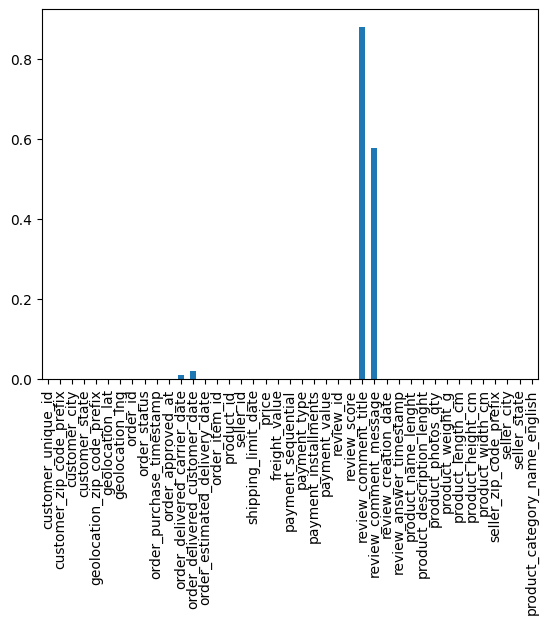

In [32]:
nanCol=df.isna().sum()/df.shape[0]
nanCol.plot.bar()

<AxesSubplot: >

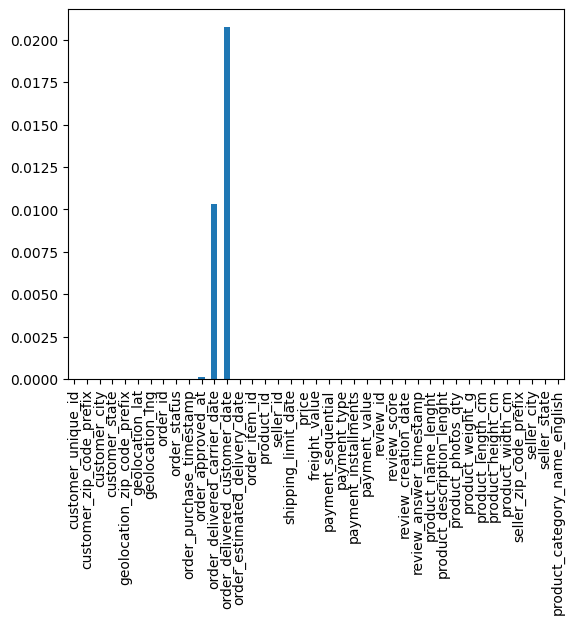

In [33]:
df.drop(["review_comment_title"], axis=1, inplace=True)# Trop de NaN dans la colonne
df.drop(["review_comment_message"], axis=1, inplace=True)# Trop de NaN dans la colonne
nanCol=df.isna().sum()/df.shape[0]
nanCol.plot.bar()

### <a id='toc4_3_3_'></a>[Suppression des lignes ne contenant pas l'information de l'acheteur](#toc0_)

In [34]:
df.customer_unique_id.isna().any()

False

## <a id='toc4_4_'></a>[Nouvelles variables](#toc0_)

### <a id='toc4_4_1_'></a>[Données sur la livraison](#toc0_)

In [35]:
df["time_to_receive"] = pd.to_datetime(df.order_delivered_customer_date) - pd.to_datetime(df.order_purchase_timestamp)
df["Exeted_time"] = pd.to_datetime(df.order_estimated_delivery_date)- pd.to_datetime(df.order_purchase_timestamp)
df.time_to_receive = df.time_to_receive.dt.seconds/3600
df.Exeted_time = df.Exeted_time.dt.seconds/3600

## Panier moyen

In [36]:
tmp2 = df.groupby('customer_unique_id', as_index=False)['payment_value'].mean()
tmp2.rename(columns = {"payment_value": "mean_payment"}, inplace=True)
tmp2

,customer_unique_id,mean_payment
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
93327,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
93328,fffea47cd6d3cc0a88bd621562a9d061,84.58
93329,ffff371b4d645b6ecea244b27531430a,112.46
93330,ffff5962728ec6157033ef9805bacc48,133.69


In [37]:
df = pd.merge(df, tmp2, on="customer_unique_id")

### <a id='toc4_4_2_'></a>[Géolocalisation du vendeur](#toc0_)
Comme pour l'acheteur nous allons utiliser la longitude et latitude plutôt que les villes

In [38]:
tmp.columns

Index(['customer_city', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng'],
      dtype='object')

In [39]:
df.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name_english', 'time_to_receive', 'Exeted_time',
       'mean_payment'],
      dtype='obj

In [40]:
tmp.rename(columns = {"customer_city" : "seller_city", "geolocation_lat": "seller_geolocation_lat",
                      "geolocation_lng": "seller_geolocation_lng", 
                      "geolocation_zip_code_prefix" : "seller_geolocation_zip_code_prefix"}, inplace=True)
tmp

,seller_city,seller_geolocation_zip_code_prefix,seller_geolocation_lat,seller_geolocation_lng
5,abadia dos dourados,38540.00000,-18.474476,-47.407837
6,abadiania,72940.00000,-16.193820,-48.708442
8,abaete,35620.00000,-19.158549,-45.446275
9,abaetetuba,68440.00000,-1.723024,-48.881065
11,abaiara,63240.00000,-7.358247,-39.045817
...,...,...,...,...
7973,xinguara,68555.29703,-7.087093,-49.925035
7974,xique-xique,47400.00000,-10.823373,-42.727130
7976,zacarias,15265.00000,-21.050431,-50.052727
7977,ze doca,65365.00000,-3.276499,-45.655054


In [41]:
df = pd.merge(df, tmp, on = "seller_city")

In [42]:
df.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name_english', 'time_to_receive', 'Exeted_time',
       'mean_payment', 'seller_geolocati

# <a id='toc5_'></a>[Exploration](#toc0_)

## <a id='toc5_1_'></a>[Historique](#toc0_)

In [43]:
print(df['order_purchase_timestamp'].min())
print(df['order_purchase_timestamp'].max())

2016-09-04 21:15:19
2018-09-03 09:06:57


## <a id='toc5_2_'></a>[Nombre de vendeurs](#toc0_)

In [44]:
df['seller_id'].nunique()

2938

## <a id='toc5_3_'></a>[Nombre de clients par vendeur](#toc0_)

In [45]:
df.groupby(['seller_id','customer_unique_id'], as_index = False).count().groupby(
    'seller_id').count()['customer_unique_id'].sum()

95012

## <a id='toc5_4_'></a>[Nombre de clients](#toc0_)

In [46]:
len(df.customer_unique_id.unique())

91624

## <a id='toc5_5_'></a>[Nombre de transactions](#toc0_)

In [47]:
len(df.order_id.unique())

94657

## <a id='toc5_6_'></a>[Nombre de commandes multiples par client](#toc0_)

(array([7.7899e+04, 1.0017e+04, 1.9310e+03, 0.0000e+00, 9.1400e+02,
        3.3300e+02, 2.9100e+02, 0.0000e+00, 6.8000e+01, 4.5000e+01,
        2.3000e+01, 0.0000e+00, 2.5000e+01, 1.6000e+01, 2.3000e+01,
        0.0000e+00, 4.0000e+00, 8.0000e+00, 6.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 7.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

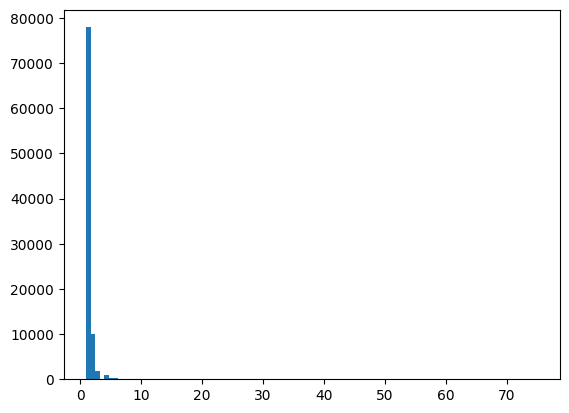

In [48]:
tmp = df.groupby('customer_unique_id')["order_item_id"].count()
plt.hist(tmp, bins = 100)

## <a id='toc5_7_'></a>[Statut des commandes](#toc0_)

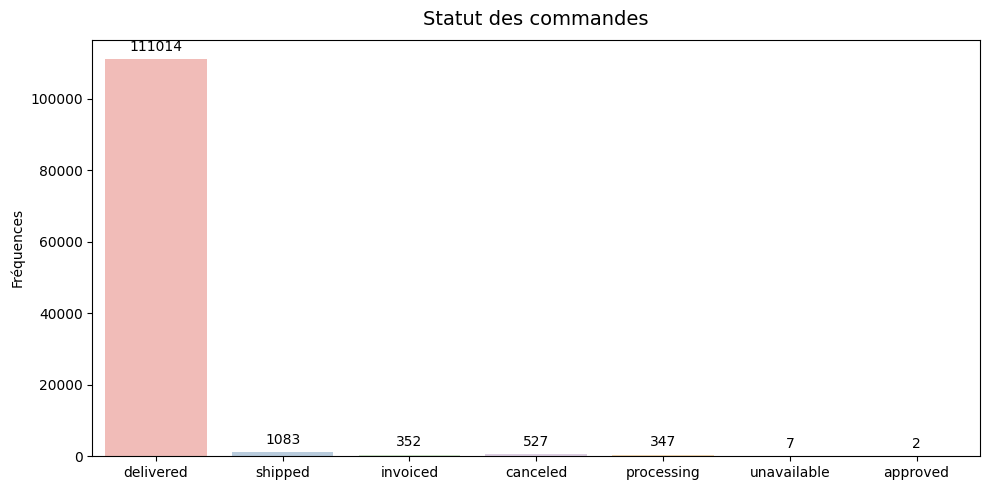

In [49]:
fig, ax = plt.subplots(figsize = (10, 5))

sn.countplot(ax = ax, x = 'order_status', data = df, palette = 
             'Pastel1').set(xlabel = None)
ax.bar_label(ax.containers[0], padding = 4)
plt.title('Statut des commandes', fontdict = {
    'fontsize': 14}, pad = 10.5)
plt.ylabel('Fréquences')

plt.tight_layout()

## <a id='toc5_8_'></a>[Nombre de commandes par région](#toc0_)

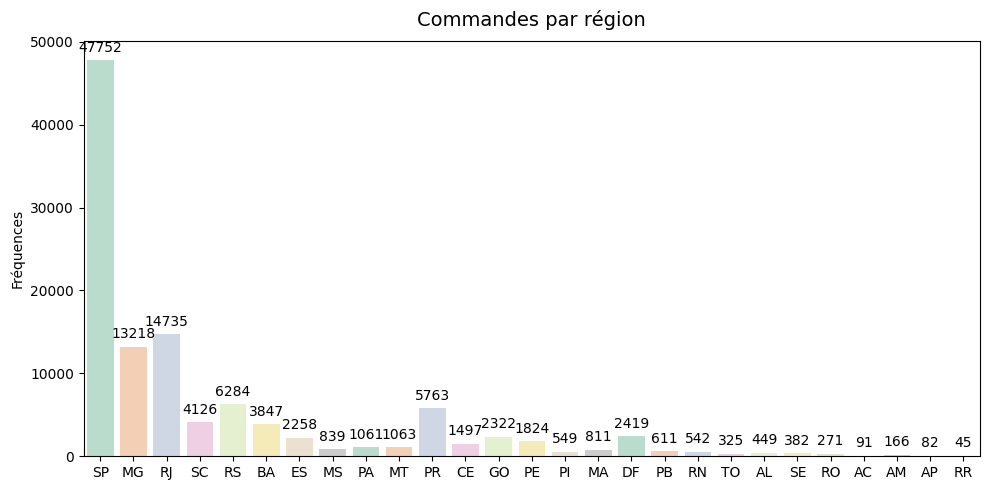

In [50]:
# Creating a plot to show number of orders by state
fig, ax = plt.subplots(figsize = (10, 5))

sn.countplot(ax = ax, x = df['customer_state'], palette = 
             'Pastel2').set(xlabel = None)
ax.bar_label(ax.containers[0], padding = 4)
plt.title('Commandes par région', fontdict = {
    'fontsize': 14}, pad = 10.5)
plt.ylabel('Fréquences')

plt.tight_layout()

## <a id='toc5_9_'></a>[Evolution des commandes dans le temps](#toc0_)

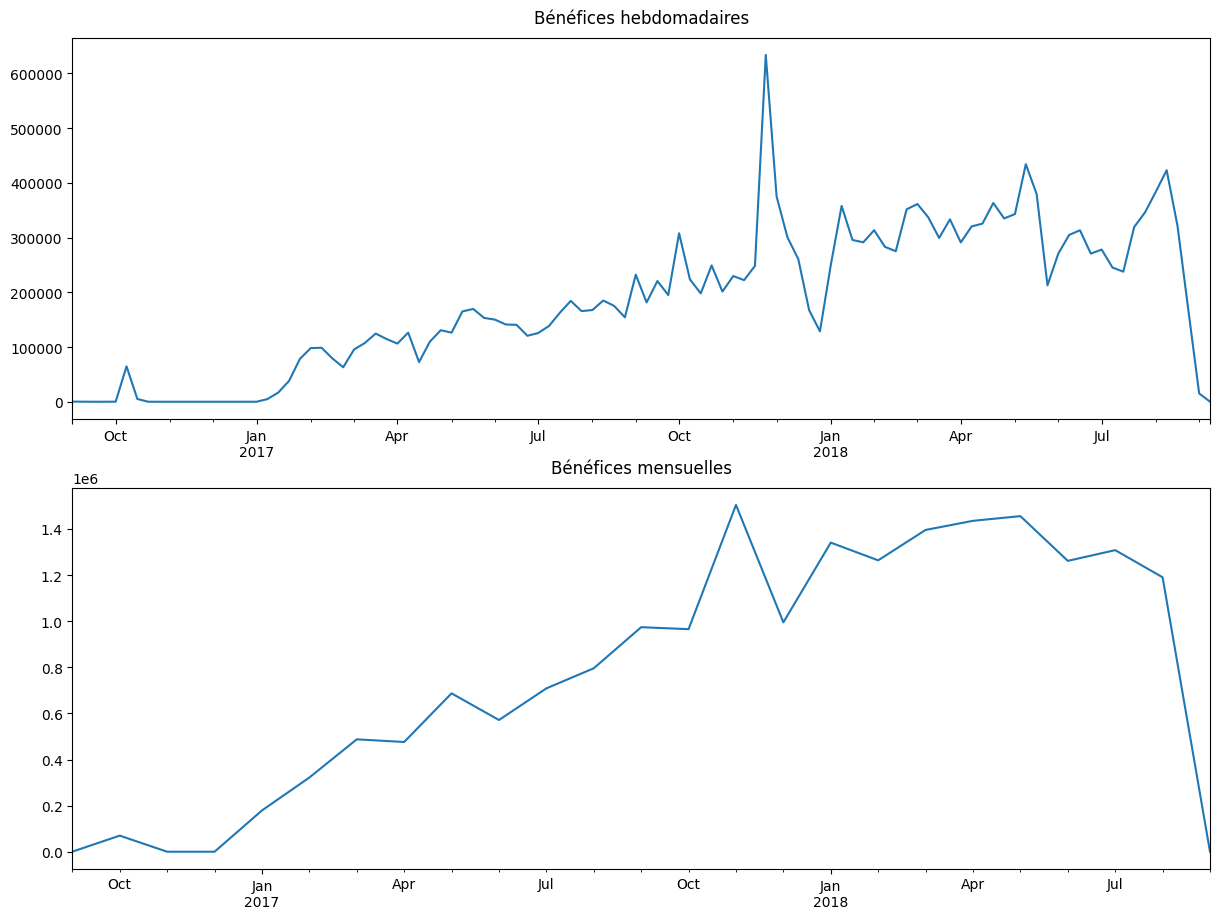

In [51]:
df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp)
data_2 = df.copy(deep = True)
data_2 = data_2.set_index(
    'order_purchase_timestamp')

plt.figure(figsize = (12, 9))

plt.subplot(2,1,1)
data_2['payment_value'].resample('W').sum().plot()
plt.title('Bénéfices hebdomadaires'
          , fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)

plt.subplot(2,1,2)
data_2['payment_value'].resample('M').sum().plot()
plt.title('Bénéfices mensuelles'
          , fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)

plt.tight_layout(pad = 0)

## <a id='toc5_10_'></a>[Nombre de commandes dans le temps](#toc0_)

## <a id='toc5_11_'></a>[Distribution des montants de paiement](#toc0_)

C:\Users\SSosa\AppData\Local\Temp\ipykernel_12196\3631050716.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sn.stripplot(y = df['payment_value'], palette = 'viridis').set(xlabel = None, ylabel = None)


Text(0.5, 1.0, 'Distribution des montants de paiement')

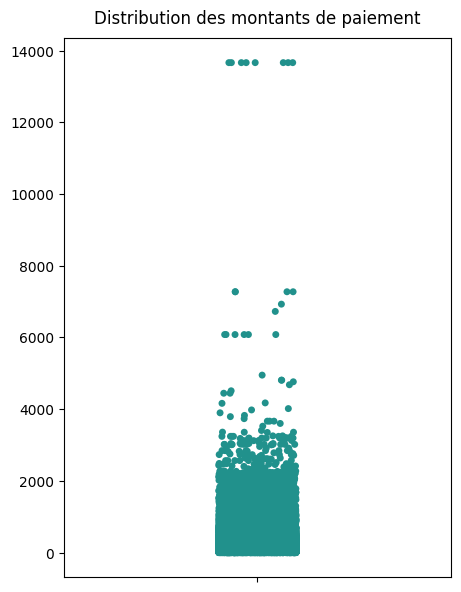

In [52]:
#Plot histogram to show distribution of payment value
plt.figure(figsize = (5, 7))

sn.stripplot(y = df['payment_value'], palette = 'viridis').set(
    xlabel = None, ylabel = None)
plt.title('Distribution des montants de paiement',
          fontdict = {'fontsize': 12}, pad = 10.5)

## <a id='toc5_12_'></a>[Type de paiement le plus couramment utilisé](#toc0_)

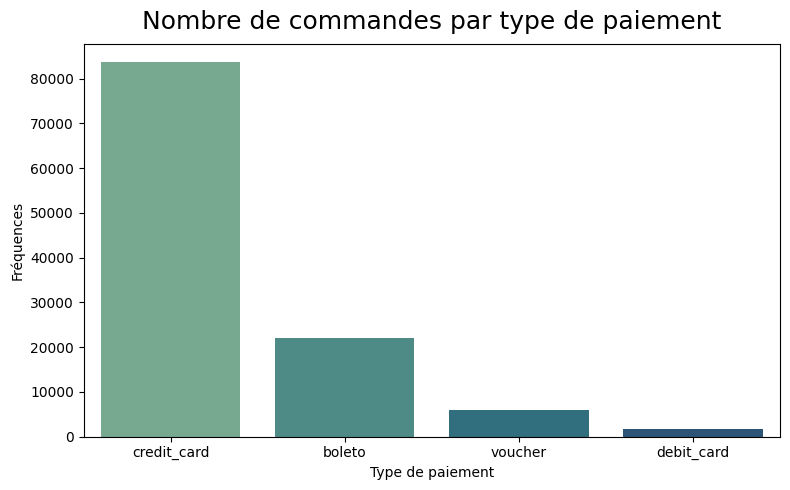

In [53]:
#Creating a countplot to show which type of payment is most commonly used
plt.figure(figsize = (8, 5))

sn.countplot(x = 'payment_type', data = df, palette = 'crest')
plt.title('Nombre de commandes par type de paiement', fontdict = {
    'fontsize': 18}, pad = 10.5)
plt.xlabel('Type de paiement')
plt.ylabel('Fréquences')

plt.tight_layout()

## <a id='toc5_13_'></a>[Principales catégories par valeur de paiement et note d'avis](#toc0_)

C:\Users\SSosa\AppData\Local\Temp\ipykernel_12196\1114941905.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_groups = df.groupby(['product_category_name_english'], as_index = False).sum().sort_values('payment_value', ascending= False).head(10)
C:\Users\SSosa\AppData\Local\Temp\ipykernel_12196\1114941905.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_groups_2 = df.groupby(['product_category_name_english'], as_index = False).mean().sort_values('review_score', ascending= False).head(10)


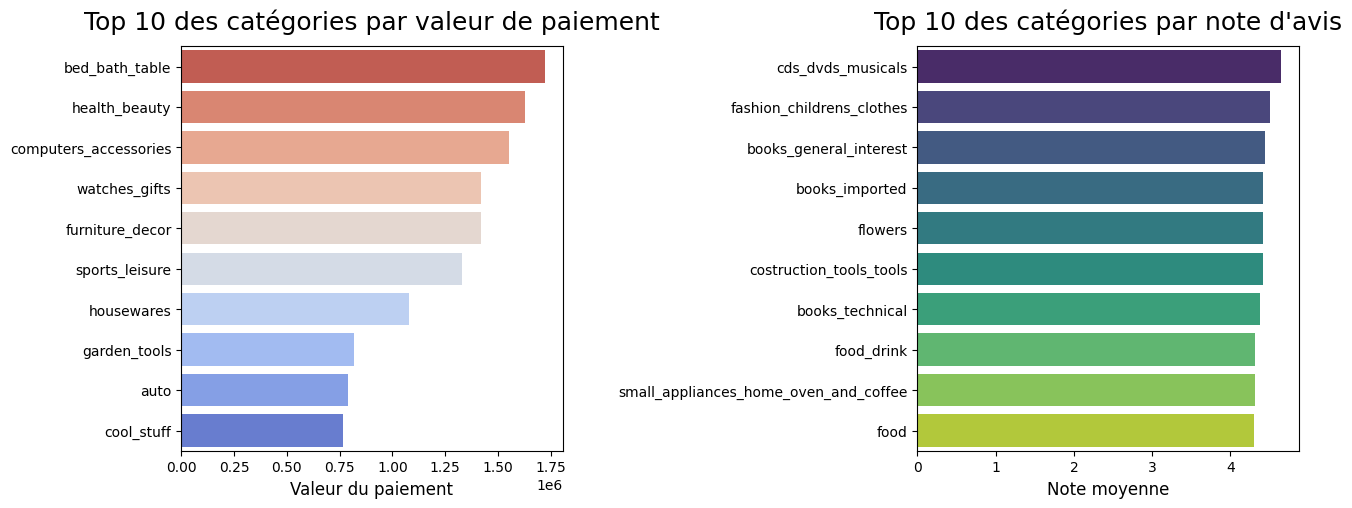

In [54]:
plt.figure(figsize = (14, 6))


plt.subplot(1,2,1)
merged_groups = df.groupby(['product_category_name_english'],
                           as_index = False).sum().sort_values('payment_value', ascending= False).head(10)

sn.barplot(data = merged_groups, x = 'payment_value',
           y = 'product_category_name_english', palette = 'coolwarm_r')
plt.ylabel(None)
plt.xlabel('Valeur du paiement', fontdict = {'fontsize': 12})
plt.title('Top 10 des catégories par valeur de paiement', fontdict = {'fontsize': 18}, pad = 12)


plt.subplot(1,2,2)
merged_groups_2 = df.groupby(['product_category_name_english'], 
                             as_index = False).mean().sort_values('review_score', ascending= False).head(10)

sn.barplot(data = merged_groups_2, x = 'review_score',
           y = 'product_category_name_english', palette = 'viridis')
plt.ylabel(None)
plt.xlabel('Note moyenne', fontdict = {'fontsize': 12})
plt.title("""Top 10 des catégories par note d'avis""", 
          fontdict={'fontsize': 18}, pad = 12)


plt.tight_layout(pad = 4)

## <a id='toc5_14_'></a>[Meilleur vendeur par valeur de paiement](#toc0_)

C:\Users\SSosa\AppData\Local\Temp\ipykernel_12196\11434395.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_groups = df.groupby(['seller_id'], as_index = False).sum().sort_values('payment_value', ascending= False).head(10)


Text(0.5, 1.0, 'Top 10 des vendeurs par valeur de paiement')

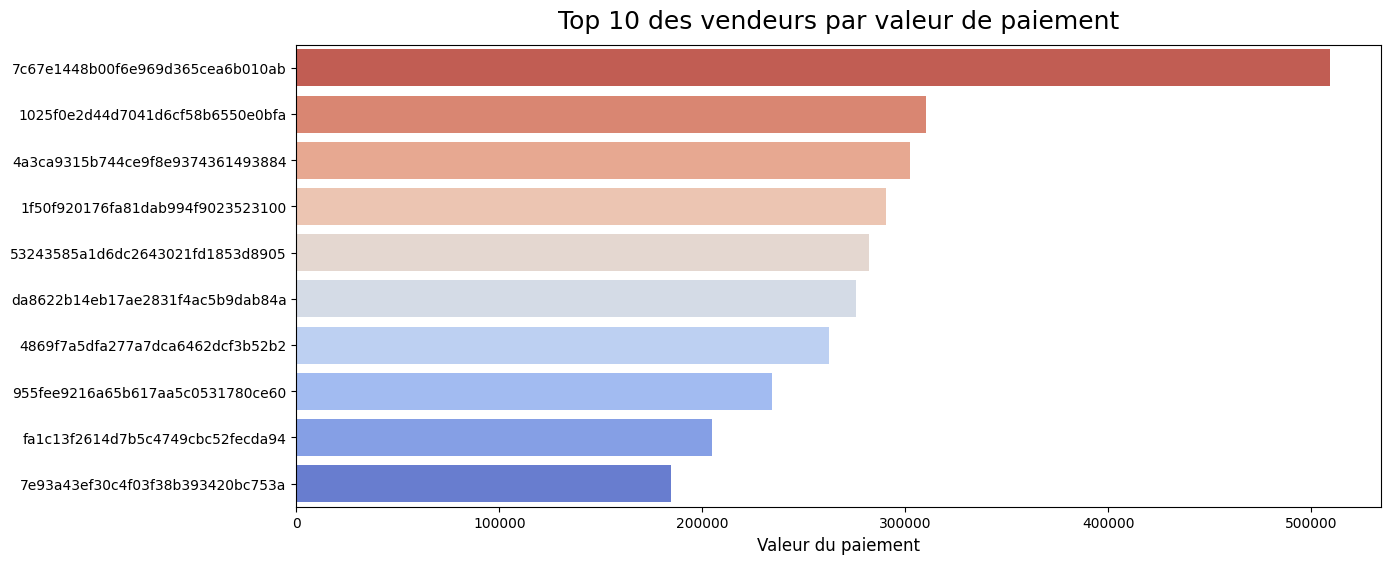

In [55]:
plt.figure(figsize = (14, 6))
merged_groups = df.groupby(['seller_id'], as_index = False).sum(
    ).sort_values('payment_value', ascending= False).head(10)

sn.barplot(data = merged_groups, x = 'payment_value',
           y = 'seller_id', palette = 'coolwarm_r')
plt.ylabel(None)
plt.xlabel('Valeur du paiement', fontdict = {'fontsize': 12})
plt.title('Top 10 des vendeurs par valeur de paiement',
          fontdict = {'fontsize': 18}, pad = 12)


## <a id='toc5_15_'></a>[Distribution des données](#toc0_)

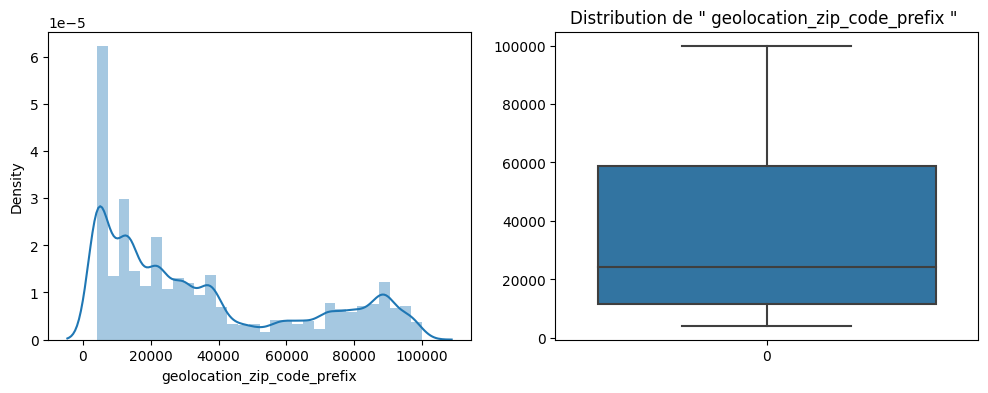

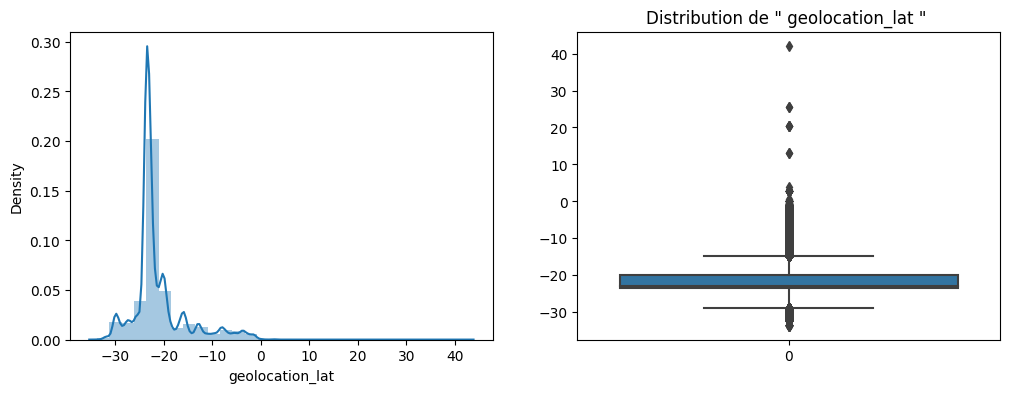

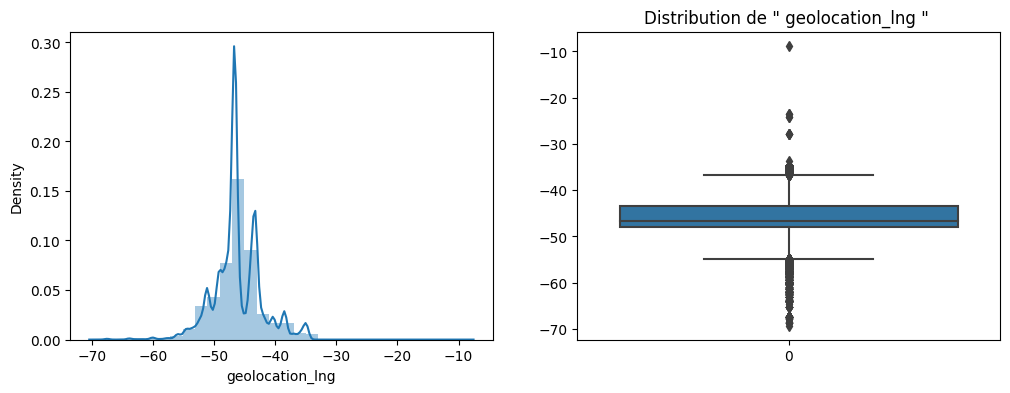

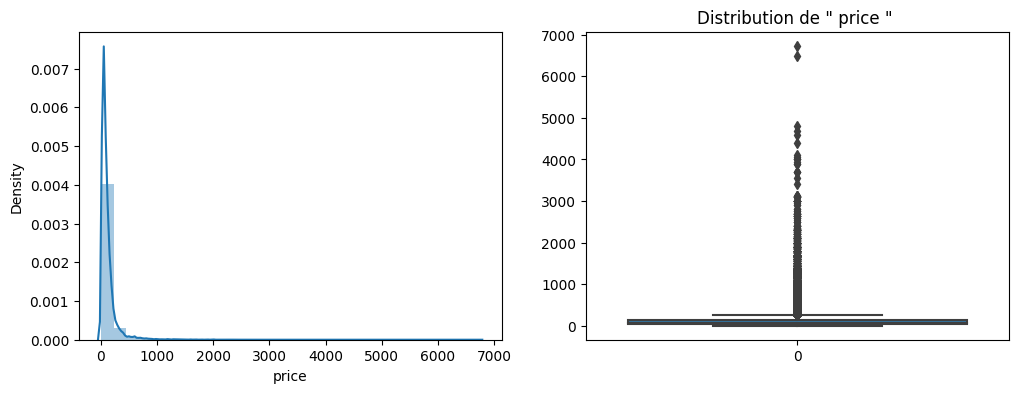

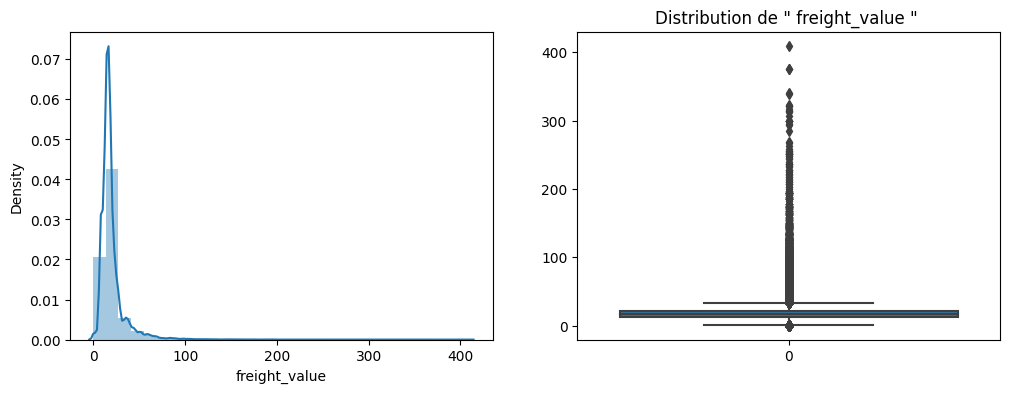

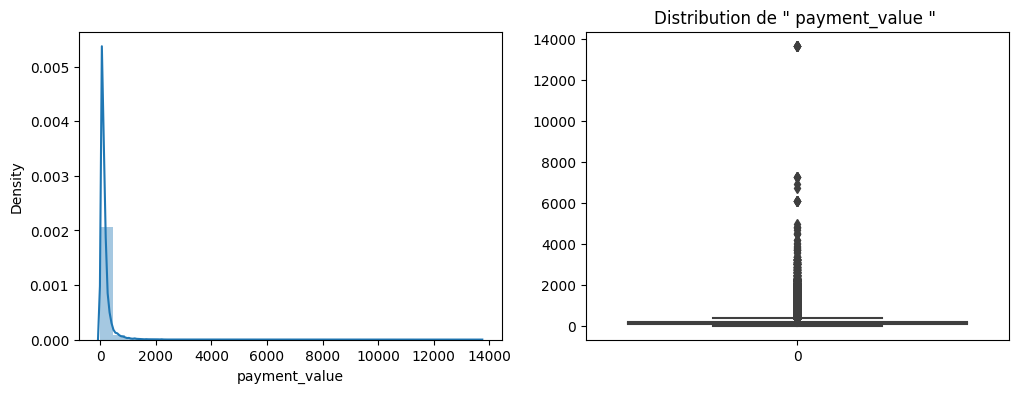

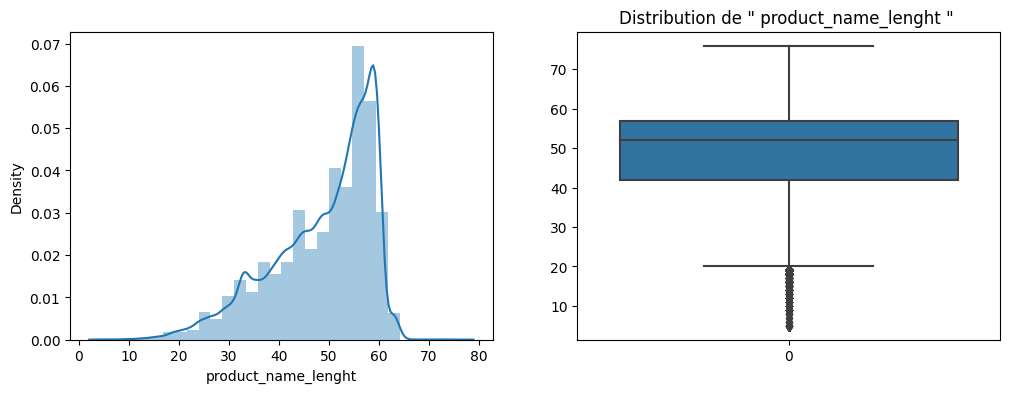

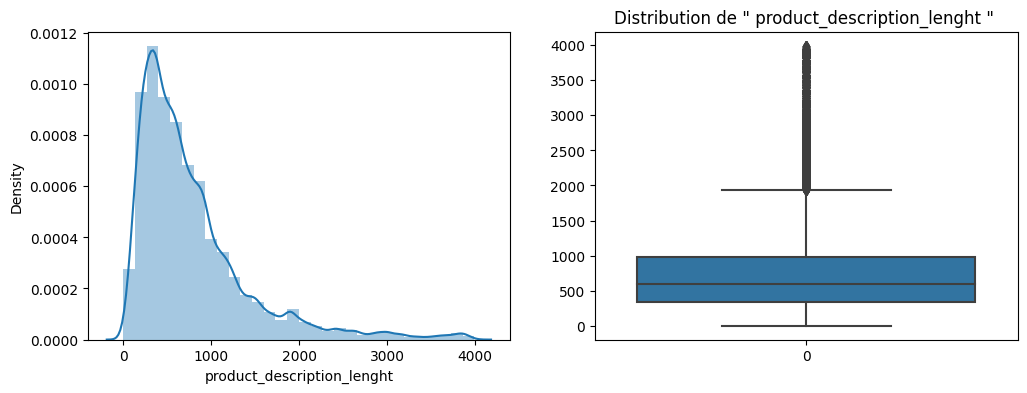

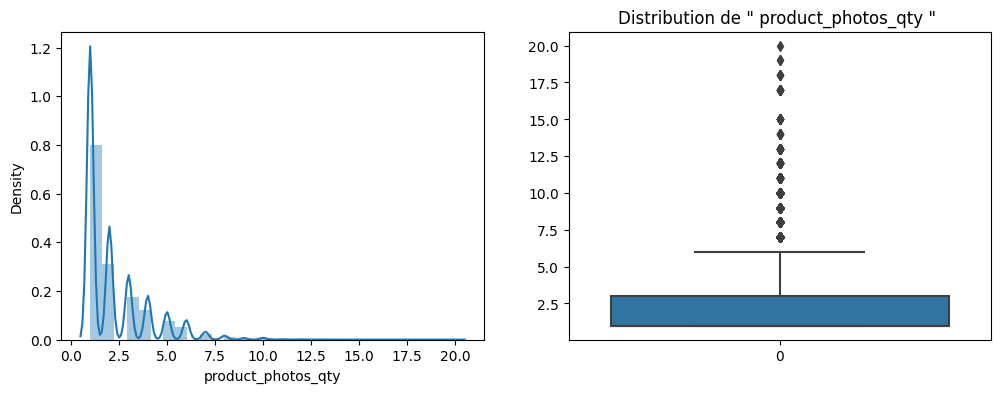

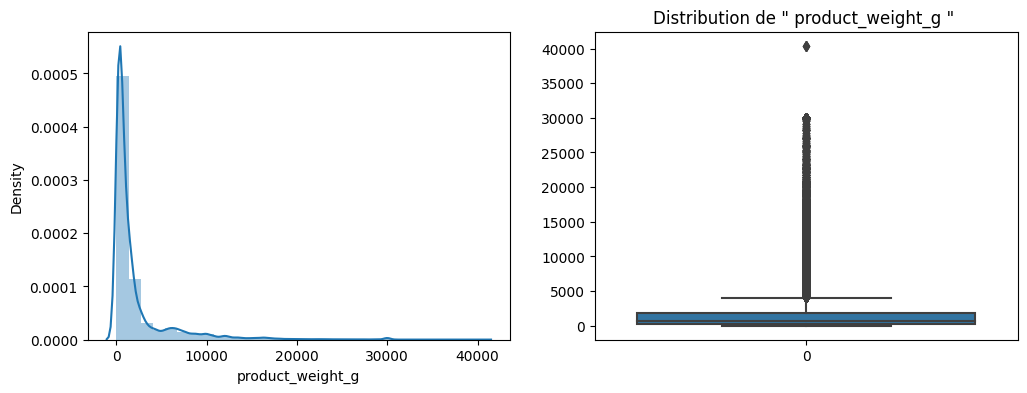

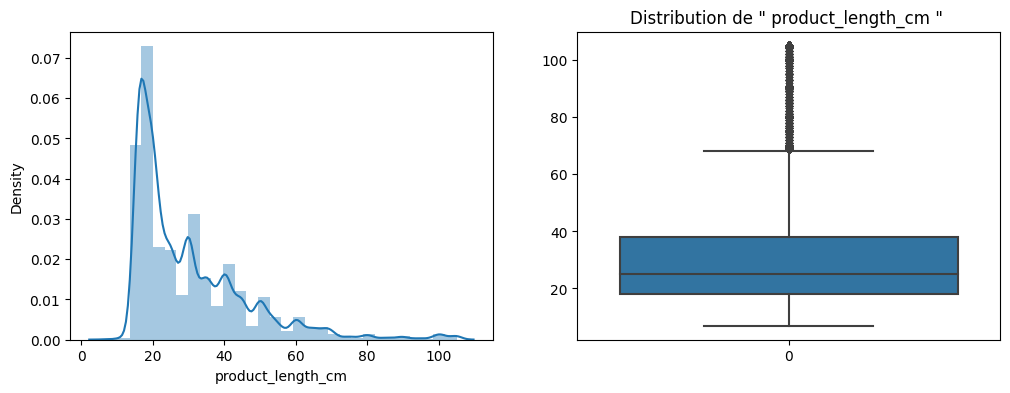

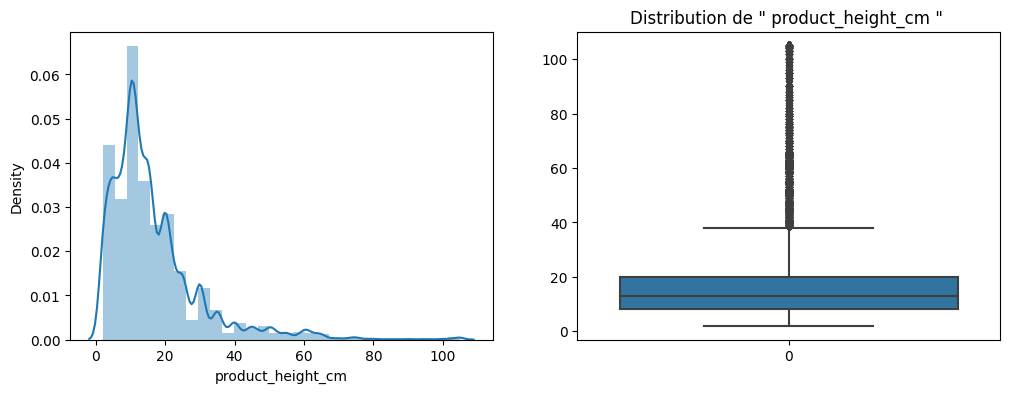

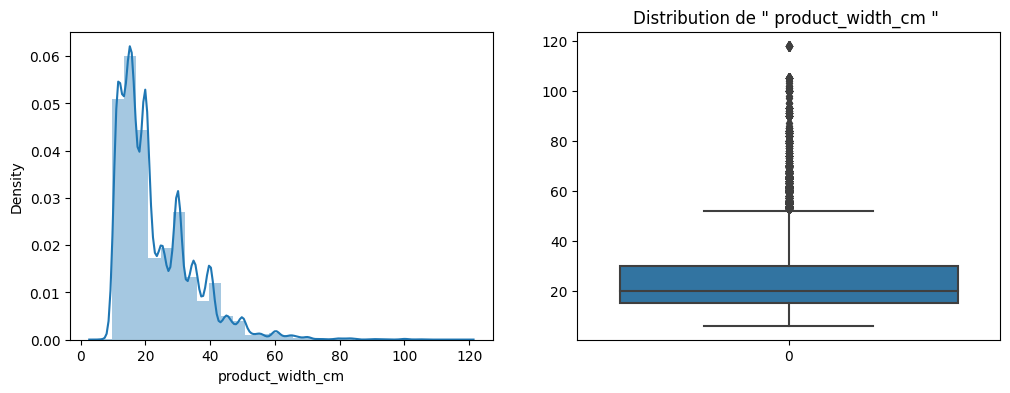

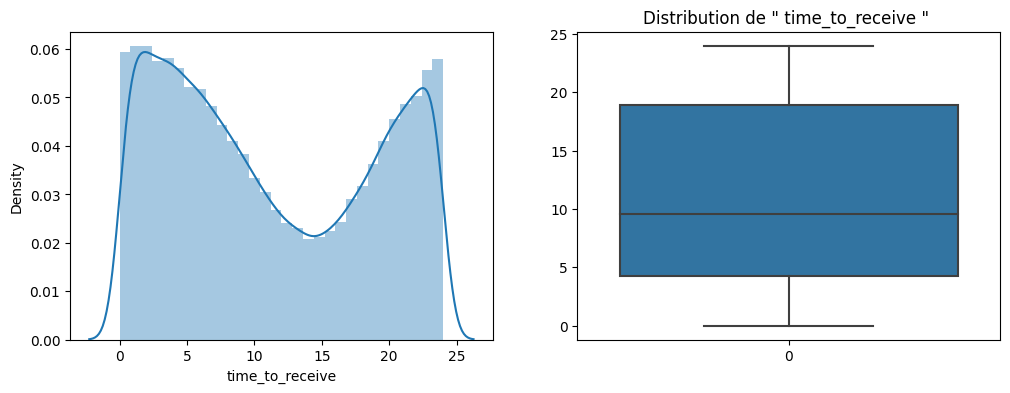

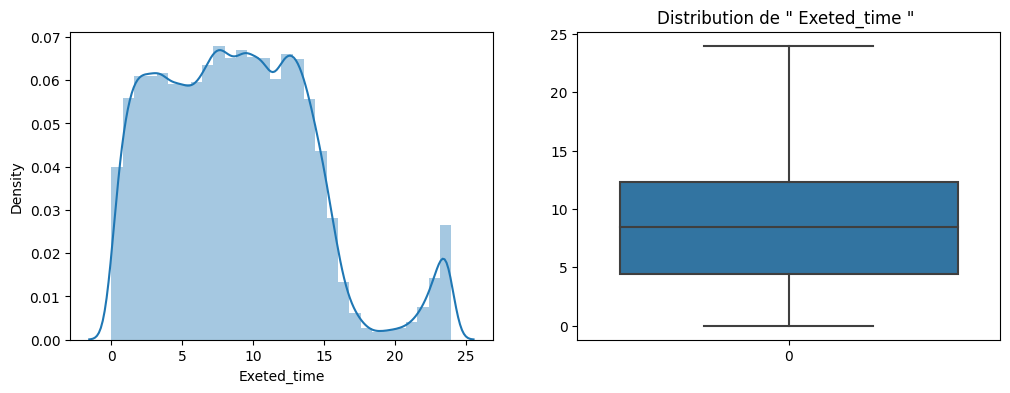

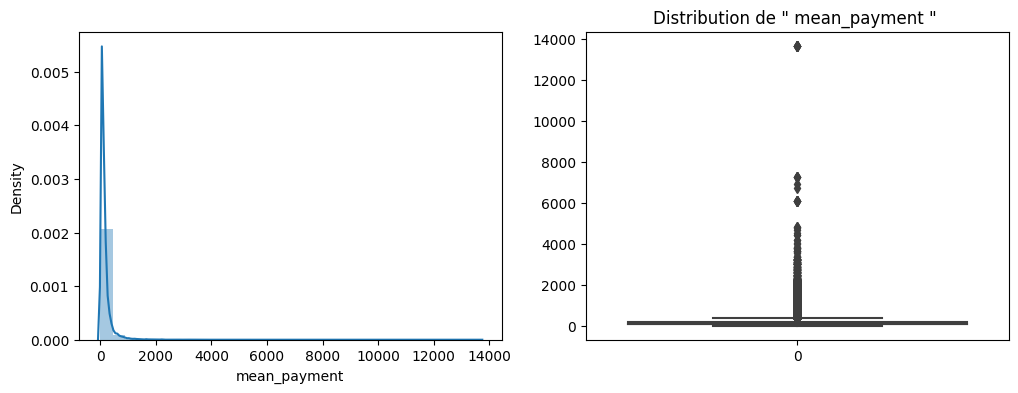

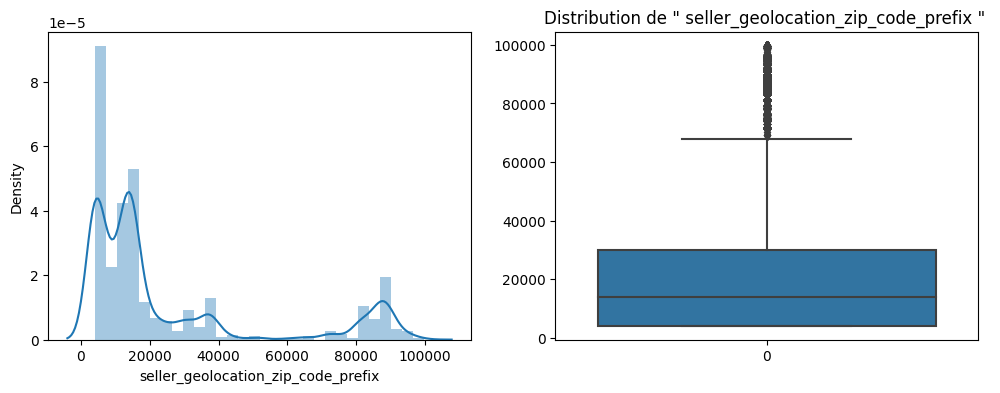

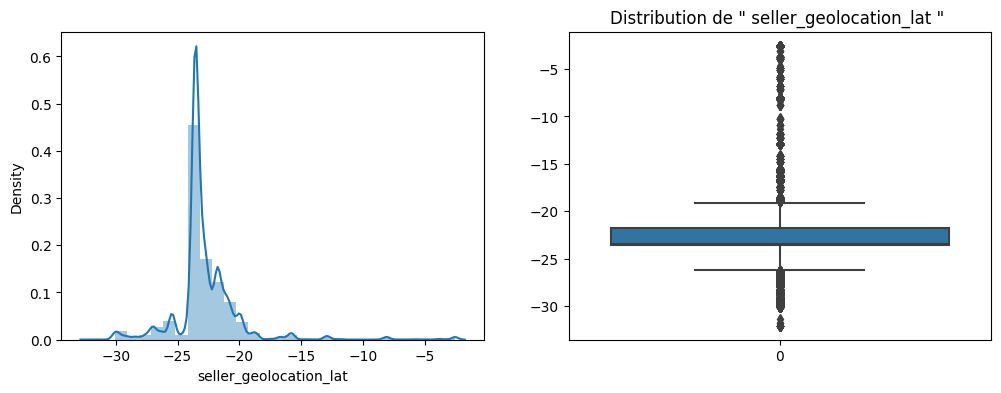

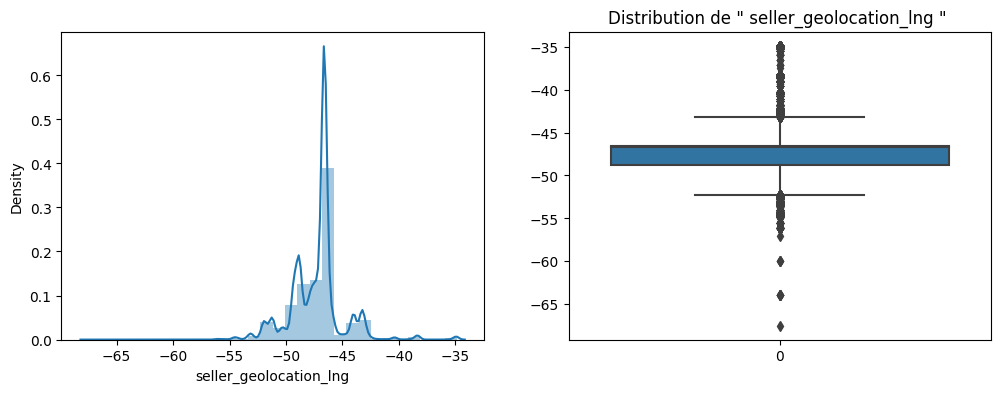

In [56]:
%matplotlib inline

for column in df.select_dtypes(['int32', 'float64']).columns:
    f, axes = plt.subplots(1,2, figsize=(12,4))
    titre = 'Distribution de ' + str(column)
    plt.title(titre)
    warnings.simplefilter("ignore")
    sn.distplot(df[column], bins=30, ax=axes[0])
    titre = """Distribution de " """ + str(column) + """ " """
    plt.title(titre)
    sn.boxplot(df[column], ax=axes[1])
    plt.show()

## <a id='toc5_16_'></a>[Correlation entre variables](#toc0_)

<AxesSubplot: >

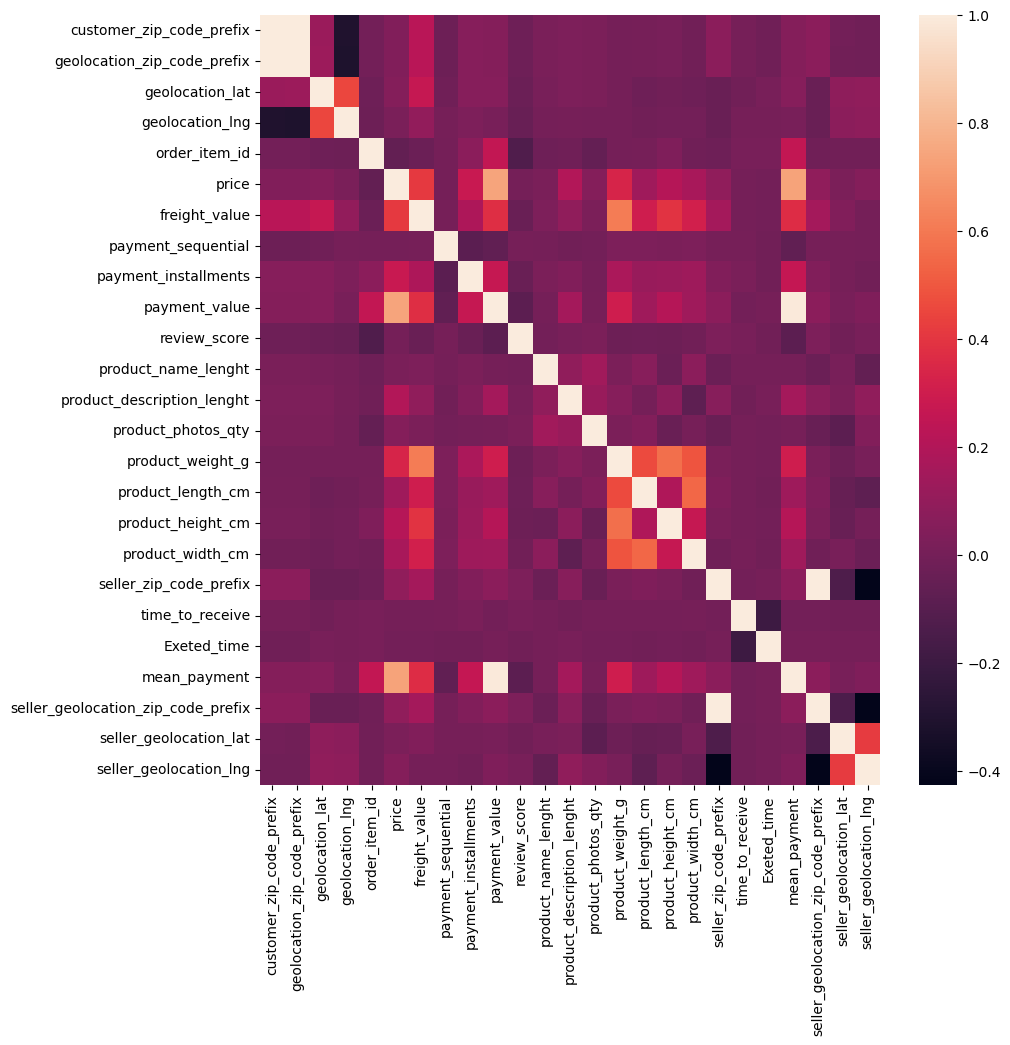

In [57]:
plt.figure(figsize=(10,10))
sn.heatmap(df.corr())

# <a id='toc6_'></a>[Selection des variables à garder pour l'analyse](#toc0_)

In [58]:
df.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name_english', 'time_to_receive', 'Exeted_time',
       'mean_payment', 'seller_geolocati

## <a id='toc6_1_'></a>[Variables supprimées](#toc0_)

Les variables liées à la livraison sont retirées car elles sont synthétisées par les variables créees: temps de livraison et excès du temps de livraison. Cependant on garde "order_purchase_timestamp" pour une analyse temporelle des clusters

In [59]:
df.drop([ 'order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date',
         'order_estimated_delivery_date', 'order_item_id', 'product_id',
         'shipping_limit_date', 'order_status'], axis = 1, inplace=True)

Seul le score de la review semble pertinent pour une analyse

In [60]:
df.drop(['review_creation_date', 'review_answer_timestamp', 'review_id'], axis = 1, inplace=True)

On va utiliser uniquement les données de moyenne de latitude et longitude comme données de géolocalisation

In [61]:
df.drop(['customer_zip_code_prefix', 'customer_state', 'customer_city'], axis = 1, inplace=True)

Pour le paiement on garde "payment_type" et sont montant "payment_value"

In [62]:
df.drop(['payment_sequential', 'payment_installments'], axis = 1, inplace=True)

La description du produit, ses dimensions et la longueur de son nom ne semblent pas être pertinentes et sont fortement corrélées entre elles ainsi qu'avec les frais de livraison (faire taille du produit/prix = un gros produit pas cher se vend mieux?).
On conserve la taille de la description et la qualité de la photo.

In [63]:
df.drop(['product_weight_g', 'product_length_cm', 'product_height_cm',
         'product_width_cm','product_name_lenght'], axis = 1, inplace=True)

Pour le vendeur on ne conserve que les informations de latitude et longitude

In [65]:
df.columns

Index(['customer_unique_id', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'order_id', 'order_purchase_timestamp', 'seller_id',
       'price', 'freight_value', 'payment_type', 'payment_value',
       'review_score', 'product_description_lenght', 'product_photos_qty',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'product_category_name_english', 'time_to_receive', 'Exeted_time',
       'mean_payment', 'seller_geolocation_zip_code_prefix',
       'seller_geolocation_lat', 'seller_geolocation_lng'],
      dtype='object')

In [66]:
df.drop(['seller_zip_code_prefix', 'seller_state', 'seller_city', 'geolocation_zip_code_prefix', 'seller_geolocation_zip_code_prefix'], axis = 1, inplace=True)

## <a id='toc6_2_'></a>[Variables numériques](#toc0_)

<AxesSubplot: >

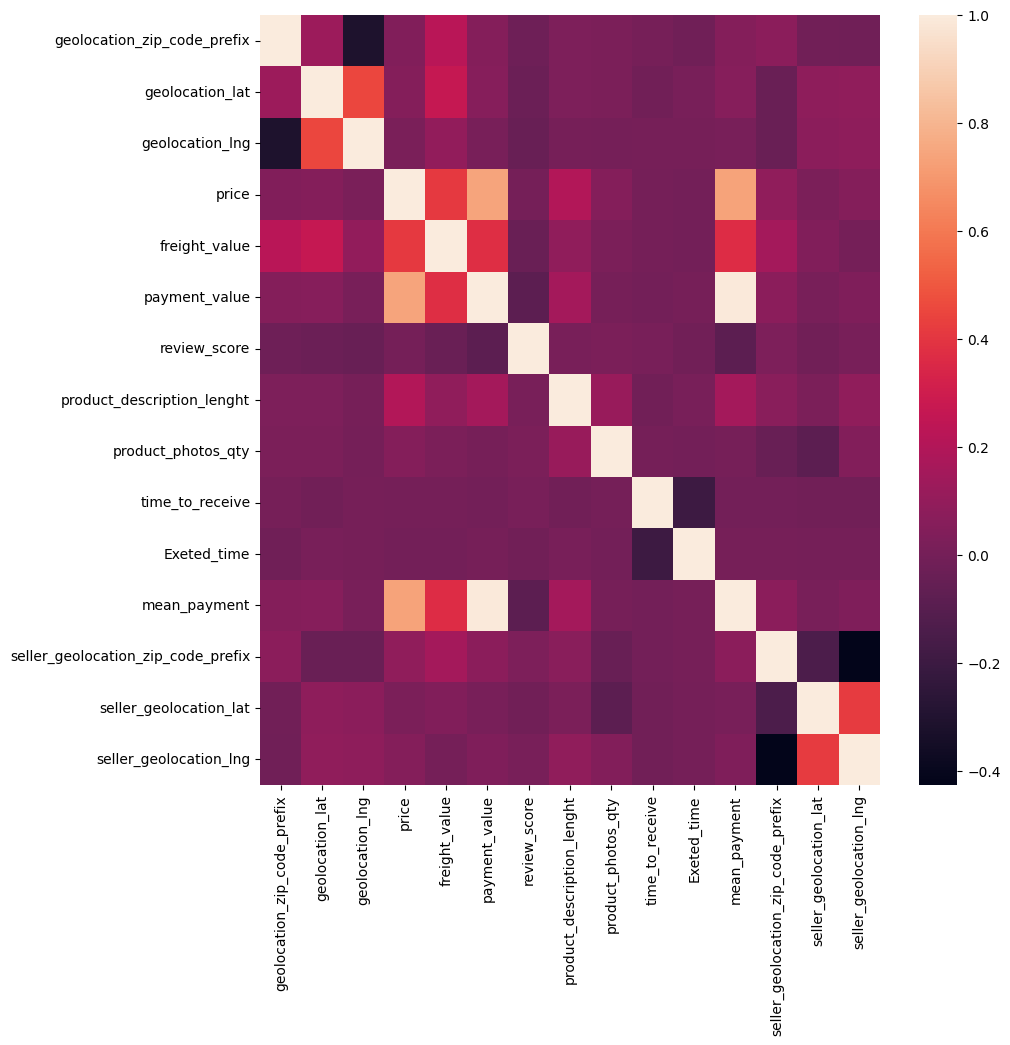

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(df.corr())

Pas de corrélations majeures

## <a id='toc6_3_'></a>[Variables catégorielles](#toc0_)

In [296]:
df.seller_id.dtypes

dtype('O')

Réduction des catérogies pour OHE

In [297]:
df.product_category_name_english.unique()

array(['office_furniture', 'sports_leisure', 'furniture_living_room',
       'furniture_decor', 'auto', 'baby', 'luggage_accessories',
       'fashion_bags_accessories', 'health_beauty',
       'kitchen_dining_laundry_garden_furniture', 'bed_bath_table',
       'toys', 'computers_accessories', 'home_construction',
       'garden_tools', 'housewares', 'construction_tools_lights',
       'fashion_male_clothing', 'books_general_interest', 'cool_stuff',
       'air_conditioning', 'home_confort', 'electronics', 'watches_gifts',
       'telephony', 'books_technical', 'industry_commerce_and_business',
       'stationery', 'flowers', 'fixed_telephony', 'food_drink', 'food',
       'perfumery', 'costruction_tools_garden', 'costruction_tools_tools',
       'market_place', 'audio', 'musical_instruments',
       'tablets_printing_image', 'home_appliances',
       'construction_tools_construction', 'fashion_sport', 'pet_shop',
       'furniture_mattress_and_upholstery', 'drinks',
       'agro_indus

In [298]:
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("furniture"),
                                            'furniture', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["home_confort",
                                                                                   "home_comfort_2", "bed_bath_table"]), 'home_comfort', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("home_appliances"),
                                            'home_appliances', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("books"),
                                            'books', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("drink"),
                                            'drinks', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("construction"),
                                            'construction', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("computers"),
                                            'computers', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("tools"),
                                            'tools', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("telephony"),
                                            'telephony', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("industry"), 
                                            'industry', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("game"),
                                            'gaming', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["dvds_blu_ray",
                                                                                   "cine_photo"]), 'moovies', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["health_beauty",
                                                                                   "perfumery", "diapers_and_hygiene", ]), 'informatica', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("supplies"),
                                            'supplies', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("fashion"),
                                            'fashion', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("fashio"),
                                            'fashion', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.str.contains("informatica"),
                                            'computers', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["cds_dvds_musicals",
                                                                                   "perfumery", "music","musical_instruments" ]), 'audio', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["housewares",
                                                                                   "home_comfort", "music", "small_appliances_home_oven_and_coffee","la_cuisine"]), 'house', df.product_category_name_english )
df.product_category_name_english = np.where(df.product_category_name_english.isin(["computers",
                                                                                   "tablets_printing_image"]), 'informatic', df.product_category_name_english )
df.product_category_name_english.unique()

array(['furniture', 'sports_leisure', 'auto', 'baby',
       'luggage_accessories', 'fashion', 'informatic', 'house', 'toys',
       'construction', 'tools', 'books', 'cool_stuff', 'air_conditioning',
       'electronics', 'watches_gifts', 'telephony', 'industry',
       'stationery', 'flowers', 'drinks', 'food', 'market_place', 'audio',
       'home_appliances', 'pet_shop', 'moovies', 'small_appliances',
       'arts_and_craftmanship', 'signaling_and_security', 'gaming', 'art',
       'supplies', 'security_and_services'], dtype=object)

Fréquence des différents labels pour définir un seuil

In [299]:
catFr(df, "payment_type")

credit_card    0.737894
boleto         0.194685
voucher        0.053136
debit_card     0.014285
Name: payment_type, dtype: float64

In [300]:
catFr(df, "product_category_name_english")

informatic                0.189488
house                     0.172811
furniture                 0.098172
sports_leisure            0.076157
watches_gifts             0.054301
telephony                 0.043456
tools                     0.042698
auto                      0.038048
toys                      0.037059
cool_stuff                0.034703
baby                      0.026947
electronics               0.024839
fashion                   0.024389
stationery                0.022774
construction              0.018230
pet_shop                  0.017683
audio                     0.010015
gaming                    0.009865
home_appliances           0.009609
luggage_accessories       0.008135
books                     0.007844
small_appliances          0.006141
drinks                    0.005347
industry                  0.004562
food                      0.004235
market_place              0.002912
air_conditioning          0.002577
art                       0.001853
signaling_and_securi

In [301]:
df.columns

Index(['customer_unique_id', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'order_id', 'order_purchase_timestamp', 'seller_id',
       'price', 'freight_value', 'payment_type', 'payment_value',
       'review_score', 'product_description_lenght', 'product_photos_qty',
       'product_category_name_english', 'time_to_receive', 'Exeted_time',
       'mean_payment', 'seller_geolocation_zip_code_prefix',
       'seller_geolocation_lat', 'seller_geolocation_lng'],
      dtype='object')

In [302]:
tmp = OHEfr(df.drop(["customer_unique_id", "seller_id"], axis=1), thershold=0.006141)
tmp.shape

 In order_idall categories are bellow the thershold


(113332, 42)

In [303]:
tmp["customer_unique_id"] = df.customer_unique_id
tmp["seller_id"] = df.seller_id
tmp["order_id"] = df.order_id

In [304]:
tmp.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'order_purchase_timestamp', 'price', 'freight_value', 'payment_value',
       'review_score', 'product_description_lenght', 'product_photos_qty',
       'time_to_receive', 'Exeted_time', 'mean_payment',
       'seller_geolocation_zip_code_prefix', 'seller_geolocation_lat',
       'seller_geolocation_lng', 'payment_type_boleto',
       'payment_type_credit_card', 'payment_type_debit_card',
       'payment_type_voucher', 'product_category_name_english_audio',
       'product_category_name_english_auto',
       'product_category_name_english_baby',
       'product_category_name_english_books',
       'product_category_name_english_construction',
       'product_category_name_english_cool_stuff',
       'product_category_name_english_electronics',
       'product_category_name_english_fashion',
       'product_category_name_english_furniture',
       'product_category_name_english_gaming',
       'product_ca

# <a id='toc7_'></a>[Suppression des cellules vides](#toc0_)

In [305]:
tmp.dropna(inplace=True)

In [306]:
tmp.shape

(111013, 45)

# <a id='toc8_'></a>[Sauvegarde du tableau final](#toc0_)

In [307]:
import pickle
save = open("data.pickle", "wb")
pickle.dump(tmp, save)
save.close()